In [1]:
import numpy as np
import pandas as pd
# np.random.seed(4)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import gym
import random
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
model = Sequential()
model.add(Dense(48, input_shape=(6, ), activation="tanh"))
model.add(Dense(48, activation="relu"))
model.add(Dense(48, activation="tanh"))
model.add(Dense(48, activation="relu"))
model.add(Dense(1, activation="linear"))

Instructions for updating:
Colocations handled automatically by placer.


In [48]:
class DQN():
    
    def __init__(self, model, observation_size, env, alpha=0.01, gamma=0.9, 
                 exploration_params={'epsilon': 1, 'max_epsilon': 1.0, 'epsilon_decay': 0.995},
                 batch_size=30, epochs=20, explore='epsilon', number_of_episodes=50, loss='mse',
                 full_memory_replay=True, set_limit_on_learning=False, learning_render=False):
        
        self.observation_size = observation_size
        self.alpha = alpha
        self.gamma = gamma
        self.exploration_params = exploration_params
        self.batch_size = batch_size
        self.epochs = epochs
        self.env = env
#         self.env._max_episode_steps = game_limit
        self.action_space = list(range(self.env.action_space.n))
        self.number_of_episodes = number_of_episodes
        self.explore = explore
        self.tmp_memory = np.empty((0, self.observation_size+self.env.action_space.n+1))
        self.memory = np.empty((0, self.observation_size+self.env.action_space.n+1))
        self.full_memory = np.empty((0, self.observation_size+self.env.action_space.n+1))
        self.full_memory_replay = full_memory_replay
        self.reward_per_episode = []
        self.set_limit_on_learning = set_limit_on_learning
        self.learning_render = learning_render

        self.model = model
        self.model.compile(loss=loss, optimizer=Adam(lr=self.alpha))
        
        
    def monte_carlo(self, reward_list):
        """
        Value function is calculated by Monte-Carlo technique
        """
        
        q_value_list = []
        for i, _ in enumerate(reward_list):
            q_value_list.append(reward_list[i] + self.gamma*np.sum(reward_list[i+1:]))
          
        return q_value_list
    
    
    def epsilon_greedy(self, state):
        """
        This function is based on simple epsilon greedy technique, chooses action with max q-value
        with epsilon randomness, if uniformly random chosen number is biger than the epsilon number
        action is chosen randomly, otherwise argmax. This is an attemnt to solve exploration-exploitation
        problem.
        """
        
        actions_one_hot = pd.Series(self.action_space)
        actions_one_hot = pd.get_dummies(actions_one_hot)
        _state = np.array(state)
        if np.random.rand() <= self.exploration_params['epsilon']:
            action_q_values = []
           
            
            for a in self.action_space:
                # give to the model to predict q-value for every state action pair
                current_state = np.append(_state, actions_one_hot.iloc[a].values)
                current_state = current_state.reshape((1,-1))
                action_q_values.append(self.model.predict(current_state))
            
            action = np.argmax(action_q_values)
            next_state, re, done, inf = self.env.step(action)
            
            if not done:
                self.tmp_memory = np.append(self.tmp_memory,
                                            [np.append(_state,
                                                       np.array([np.append(actions_one_hot.iloc[action].values, re)]))], axis=0) #np.append(self.tmp_memory,
                
                return False, next_state
                
            else:
                q_s = self.monte_carlo(self.tmp_memory[:, -1])
                
                self.reward_per_episode.append(np.sum(self.tmp_memory[:, -1]))
                self.memory = np.insert(np.delete(self.tmp_memory, -1, 1),
                                len(self.tmp_memory[0])-1, q_s, axis=1)
                
                self.full_memory = np.append(self.full_memory, self.memory, axis=0)
                
                self.tmp_memory = np.empty((0, self.observation_size+len(self.action_space)+1))
                _state = next_state
                
                return True, next_state
           
            
        else:
            if self.exploration_params['epsilon'] <= self.exploration_params['max_epsilon']:
                self.exploration_params['epsilon'] /= self.exploration_params['epsilon_decay']

            action = np.random.choice(self.action_space, 1)[0]
            next_state, re, done, inf = self.env.step(action)
            # decay epcilon with epsilon_decay parameter
            if not done:
                self.tmp_memory = np.append(self.tmp_memory, [np.append(_state, np.array([np.append(actions_one_hot.iloc[action].values, re)]))], axis=0) #np.append(self.tmp_memory,

                return False, next_state

            else:
                q_s = self.monte_carlo(self.tmp_memory[:, -1])
                
                self.reward_per_episode.append(np.sum(self.tmp_memory[:, -1]))
                self.memory = np.insert(np.delete(self.tmp_memory, -1, 1),
                                len(self.tmp_memory[0])-1, q_s, axis=1)
                
                self.full_memory = np.append(self.full_memory, self.memory, axis=0)

                self.tmp_memory = np.empty((0, self.observation_size+len(self.action_space)+1))
                _state = next_state

                return True, next_state
                
    def Boltzman(self, state):
        """
        Boltzman exploration is a technique for exploration-exploitation dillema possible sollution.
        The idea is that every action is chosen randomly by probability.
        This method is almost the Boltzman exploration technique because I used just manualy calculated probability.
        The reason behind it is that when using Softmax I found out that difference between classes is huge, even though
        before softmax it was small, which is predictable.
        """
        actions_one_hot = pd.Series(self.action_space)
        actions_one_hot = pd.get_dummies(actions_one_hot)
        _state = np.array(state)

        action_q_values = []

        for a in self.action_space:
            # give to the model to predict q-value for every state action pair
            current_state = np.append(_state, actions_one_hot.iloc[a].values)
            current_state = current_state.reshape((1,-1))
            action_q_values.append(int(self.model.predict(current_state)))
        
        if sum(action_q_values) == 0:
            action_q_values = list(np.ones(len(action_q_values)))
            
        action_q_values = [0.000001 if i < 0 else i for i in action_q_values]
        
        print(action_q_values)
        acts_probs = [x/sum(action_q_values) for x in action_q_values]
        
        
        action = np.random.choice(self.env.action_space.n, 1, p=acts_probs)[0]
        next_state, re, done, inf = self.env.step(action)

        if not done:
            self.tmp_memory = np.append(self.tmp_memory,
                                        [np.append(_state,
                                                   np.array([np.append(actions_one_hot.iloc[action].values, re)]))], axis=0) #np.append(self.tmp_memory,

            return False, next_state

        else:
            q_s = self.monte_carlo(self.tmp_memory[:, -1])

            self.reward_per_episode.append(np.sum(self.tmp_memory[:, -1]))
            self.memory = np.insert(np.delete(self.tmp_memory, -1, 1),
                            len(self.tmp_memory[0])-1, q_s, axis=1)

            self.full_memory = np.append(self.full_memory, self.memory, axis=0)

            self.tmp_memory = np.empty((0, self.observation_size+len(self.action_space)+1))
            _state = next_state

            return True, next_state
    
    def greedy(self, state):
        """
        This function performs greedy policy with 100% probability
        """
        done = False
        actions_one_hot = pd.Series(self.action_space)
        actions_one_hot = pd.get_dummies(actions_one_hot)
        _state = np.array(state)
        action_q_values = []


        for a in self.action_space:
            # give to the model to predict q-value for every state action pair
            current_state = np.append(_state, actions_one_hot.iloc[a].values)
            current_state = current_state.reshape((1,-1))
            action_q_values.append(self.model.predict(current_state))

        action = np.argmax(action_q_values)
        next_state, re, done, inf = self.env.step(action)

        if done:
            return True, next_state
        
        return False, next_state
        
        
    def memory_replay(self):
        
        if self.full_memory_replay:
            
            idx = np.random.randint(len(self.full_memory), size=self.batch_size)
            batch = self.full_memory[idx, :]
            self.model.fit(x=batch[:,:-1], y=batch[:,-1],
                           epochs=self.epochs, verbose=0, shuffle=True)
        
        else:
            self.model.fit(x=self.memory[:,:-1], y=self.memory[:,-1],
                       batch_size=self.batch_size, epochs=self.epochs, verbose=0, shuffle=True)
            
    def plot_progress(self):
        """
        Plots episode cumulative reward, per episode
        """
        episode = list(range(len(self.reward_per_episode)))
        plt.plot(episode, self.reward_per_episode, color='g')
            
        
    def act(self, acting_method='learn'):
        """
        Plays the game based on user preferences - like method of exploration,
        number of episodes (that's all for now, but hopefully will add more features in future)
        """
        
        if acting_method == 'learn':
            
            explore = self.epsilon_greedy
            if self.explore == 'Boltzman':
                explore = self.Boltzman

#             elif self.explore == 'other_method':
#                 explore = self.other_method

            for i in range(self.number_of_episodes):
                timestamp = 0
                done = False
                state = self.env.reset()
                
                print('episode {}'.format(i))
                while not done:
                    if self.learning_render:
                        self.env.render()
                    done, next_state = explore(state)
                    state = next_state
                    if self.set_limit_on_learning:
                        if timestamp == self.env._max_episode_steps-1:
                            self.env.close()
                            print('--------------------------------------------------', i)
                            break
                        timestamp += 1
                    
                self.memory_replay()
                
            self.env.close()
                
                
        elif acting_method == 'act':
            done = False
            state = self.env.reset()
            
            while not done:
                self.env.render()
                done, next_state = self.greedy(state)
                state = next_state
             
            self.env.close()

### Let's try on Cart-pole with epsilon greedy technique

In [26]:
agent = DQN(model=model,observation_size=4, env=gym.make('CartPole-v1'), epochs=10,
                     number_of_episodes=90,
                     alpha=0.001,
                     exploration_params={'epsilon': 0.65,
                                         'max_epsilon': 1.0,
                                         'epsilon_decay': 0.99},
                     gamma=0.999, full_memory_replay=False, set_limit_on_learning=True)

In [27]:
agent.act('learn')

episode 0
episode 1
episode 2
episode 3
episode 4
-------------------------------------------------- 4
episode 5
-------------------------------------------------- 5
episode 6
-------------------------------------------------- 6
episode 7
-------------------------------------------------- 7
episode 8
-------------------------------------------------- 8
episode 9
-------------------------------------------------- 9
episode 10
-------------------------------------------------- 10
episode 11
-------------------------------------------------- 11
episode 12
-------------------------------------------------- 12
episode 13
-------------------------------------------------- 13
episode 14
-------------------------------------------------- 14
episode 15
-------------------------------------------------- 15
episode 16
-------------------------------------------------- 16
episode 17
-------------------------------------------------- 17
episode 18
-------------------------------------------------- 

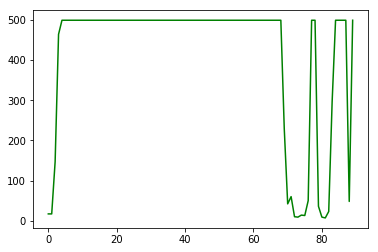

In [28]:
agent.plot_progress()

#### This is the best result for this environment

In [29]:
agent.act('act')

In [ ]:
agent.env.close()

## Now with almost-Boltzman

In [30]:
boltzman_agent = DQN(model=model,observation_size=4, env=gym.make('CartPole-v1'), epochs=10,
                     number_of_episodes=90,
                     alpha=0.01,
                     explore='Boltzman',
                     gamma=0.999, full_memory_replay=False, set_limit_on_learning=True, learning_render=False)

In [31]:
boltzman_agent.act('learn')

episode 0
[189, 191]
[197, 222]
[227, 243]
[193, 216]
[187, 188]
[191, 207]
[186, 187]
[190, 201]
[185, 186]
[182, 182]
[182, 182]
[182, 182]
[183, 183]
[182, 182]
[182, 182]
[182, 182]
[182, 182]
[181, 181]
[181, 181]
[181, 181]
[181, 181]
[181, 181]
[180, 181]
[179, 180]
episode 1
[94, 94]
[98, 103]
[115, 124]
[129, 129]
[130, 130]
[131, 150]
[131, 145]
[145, 164]
[170, 173]
[170, 173]
[171, 174]
episode 2
[40, 40]
[41, 41]
[41, 41]
[42, 42]
[41, 41]
[42, 42]
[42, 42]
[41, 41]
[42, 42]
[42, 42]
[43, 43]
[42, 42]
[43, 43]
[43, 43]
[43, 43]
[43, 43]
[43, 43]
[43, 43]
[43, 43]
[43, 43]
[42, 42]
[40, 41]
[38, 39]
[38, 38]
[38, 39]
[37, 38]
[37, 38]
[36, 37]
episode 3
[5, 5]
[4, 5]
[5, 5]
[4, 5]
[5, 5]
[4, 5]
[2, 3]
[3, 4]
[5, 5]
[5, 6]
[6, 6]
[5, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
[6, 6]
episode 4
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[2, 2]
[

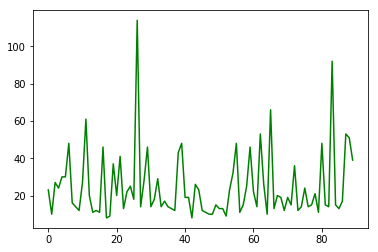

In [32]:
boltzman_agent.plot_progress()

In [34]:
boltzman_agent.act('act')

In [ ]:
boltzman_agent.env.close()

## Time for Lunar-lander

In [35]:
lunar_model = Sequential()
lunar_model.add(Dense(256, input_shape=(12, ), activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(256, activation="relu"))
lunar_model.add(Dense(256, activation="tanh"))
lunar_model.add(Dense(1, activation="linear"))

In [36]:
env_lunar = gym.make('LunarLander-v2')

In [37]:
lunar_agent = DQN(model=lunar_model, env=env_lunar, observation_size=8, epochs=100,
                           number_of_episodes=200,
                           alpha=0.001,
                           explore='Boltzman',
                           gamma=0.999, learning_render=False)

In [49]:
lunar_agent.act('learn')

episode 0
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-06, 1e-06, 1e-06, 1e-06]
[1e-

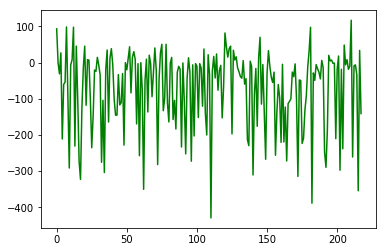

In [50]:
lunar_agent.plot_progress()

The reasons behind such horrible results are the following, if you noticed sometimes the agent preformed preatty well, but afterwards it just crashed, so the first reason is memory replay, I didn't implement full memory replay, the second reason is that model couldn't correctly split actions from each other, because I viewed action as a feature which is not that correct, another reason is that I used Monte-carlo technique to generate the objective, instead I intend to use TD learning, and further maybe TD-lambda, if I'll find it nessesary.

In [40]:
lunar_agent.act('act')

In [ ]:
lunar_agent.env.close()

In [41]:
acrobot_model = Sequential()
acrobot_model.add(Dense(48, input_shape=(9, ), activation="tanh"))
acrobot_model.add(Dense(48, activation="relu"))
acrobot_model.add(Dense(48, activation="tanh"))
acrobot_model.add(Dense(48, activation="relu"))
acrobot_model.add(Dense(48, activation="relu"))
acrobot_model.add(Dense(48, activation="tanh"))
acrobot_model.add(Dense(48, activation="tanh"))
acrobot_model.add(Dense(48, activation="relu"))
acrobot_model.add(Dense(48, activation="tanh"))
acrobot_model.add(Dense(1, activation="linear"))

In [42]:
acrobot_env = gym.make('Acrobot-v1')

In [43]:
acroagent = DQN(model=acrobot_model, env=acrobot_env, observation_size=6, epochs=50,
                           number_of_episodes=100,
                           alpha=0.0004,
                           explore='Boltzman',
                           gamma=0.999, learning_render=False)

In [44]:
acroagent.act('learn')

episode 0
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0]
[1.0, 1.0, 1.0

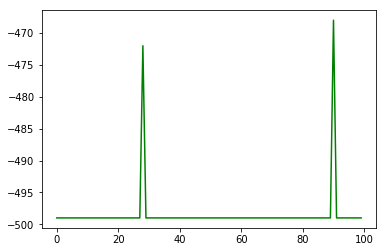

In [45]:
acroagent.plot_progress()

Acrobot performance is a bit more tricky, not because it's a harder problem than Lunar-lander, but because I don't fully understand the reward system for this environment, but hopefuly after implementing all techniques it can achieve good results.

In [ ]:
acroagent.env.close()

In [46]:
acroagent.act('act')